# Importing Important Libraries

In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the data 

In [10]:
def analyze_target_file(target_csv):
    """
    Analyze target.csv to get counts of samples
    """
    # Read target file
    targets = pd.read_csv(target_csv)
    
    # Calculate total samples
    total_samples = len(targets)
    
    # Calculate samples per label
    label_counts = targets['labels'].value_counts()
    
    print(f"Total number of samples: {total_samples}")
    print("\nSamples per label:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")
        
    # Print counts for binary classifications
    print("\nBinary classification counts:")
    
    # Face vs House
    face_house = targets[targets['labels'].isin(['face', 'house'])]
    face_count = len(face_house[face_house['labels'] == 'face'])
    house_count = len(face_house[face_house['labels'] == 'house'])
    print(f"\nFace vs House:")
    print(f"Face: {face_count}")
    print(f"House: {house_count}")
    print(f"Total: {face_count + house_count}")
    
    # Face vs Scissors
    face_scissors = targets[targets['labels'].isin(['face', 'scissors'])]
    face_count = len(face_scissors[face_scissors['labels'] == 'face'])
    scissors_count = len(face_scissors[face_scissors['labels'] == 'scissors'])
    print(f"\nFace vs Scissors:")
    print(f"Face: {face_count}")
    print(f"Scissors: {scissors_count}")
    print(f"Total: {face_count + scissors_count}")

if __name__ == "__main__":
    TARGET_CSV = "targets.csv"
    analyze_target_file(TARGET_CSV)

Total number of samples: 1452

Samples per label:
rest: 588
scissors: 108
face: 108
cat: 108
shoe: 108
house: 108
scrambledpix: 108
bottle: 108
chair: 108

Binary classification counts:

Face vs House:
Face: 108
House: 108
Total: 216

Face vs Scissors:
Face: 108
Scissors: 108
Total: 216


## Preprocessing the data for binary classification


In [15]:
def create_binary_dataset(base_folder, region, target_csv, label1, label2):
    """
    Create binary classification dataset for one region
    """
    print(f"\nProcessing {label1} vs {label2} for region {region}")
    
    # Read feature file (space-separated, no header)

    print(region)

    if region == "vt":

        feature_file = os.path.join(base_folder, region, "features.csv")
        features = pd.read_csv(feature_file, header=None, sep=' ')
    else:
        region_full = os.path.join(region, "RL")
        feature_file = os.path.join(base_folder, region_full, "features.csv")
        print(feature_file)
        features = pd.read_csv(feature_file, header=None, sep=' ')

    
    # Read target labels
    targets = pd.read_csv(target_csv)
    
    # Filter for required labels
    mask = targets['labels'].isin([label1, label2])
    filtered_targets = targets[mask]
    
    # Get features for selected labels using row indices
    selected_features = features.iloc[filtered_targets.index - 1]
    
    # Create binary labels (0 for label1, 1 for label2)
    binary_labels = (filtered_targets['labels'] == label2).astype(int)
    
    # Create final dataframe
    final_df = selected_features.copy()
    final_df['label'] = binary_labels.values
    final_df['label_name'] = filtered_targets['labels'].values
    
    # Save to CSV without index and without numbering the feature columns

    output_file = f"{region}_{label1}_vs_{label2}.csv"
    final_df.to_csv(output_file, index=False, header=False)
    print(f"Created {output_file}")
    print(f"Number of {label1}: {sum(binary_labels == 0)}")
    print(f"Number of {label2}: {sum(binary_labels == 1)}")

def main():
    # Settings
    BASE_FOLDER = "subj1"  # Change this to your base folder path
    REGIONS = ["vt", "Inferior_frontal"]
    TARGET_CSV = "targets.csv"
    
    # Process each region
    for region in REGIONS:
        # Create face vs house dataset
        create_binary_dataset(BASE_FOLDER, region, TARGET_CSV, "face", "house")
        
        # Create face vs scissors dataset
        create_binary_dataset(BASE_FOLDER, region, TARGET_CSV, "face", "scissors")

if __name__ == "__main__":
    main()


Processing face vs house for region vt
vt
Created vt_face_vs_house.csv
Number of face: 108
Number of house: 108

Processing face vs scissors for region vt
vt


Created vt_face_vs_scissors.csv
Number of face: 108
Number of scissors: 108

Processing face vs house for region Inferior_frontal
Inferior_frontal
subj1/Inferior_frontal/RL/features.csv
Created Inferior_frontal_face_vs_house.csv
Number of face: 108
Number of house: 108

Processing face vs scissors for region Inferior_frontal
Inferior_frontal
subj1/Inferior_frontal/RL/features.csv
Created Inferior_frontal_face_vs_scissors.csv
Number of face: 108
Number of scissors: 108


In [18]:
def load_and_preprocess(file_path):
    """Load and preprocess the data"""
    # Read CSV
    data = pd.read_csv(file_path, header=None)
    
    # Last two columns are label and label_name
    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2].values  # Binary label (0 or 1)
    label_names = data.iloc[:, -1].values  # Label names
    
    # Print dataset information
    unique_labels, counts = np.unique(label_names, return_counts=True)
    print("\nDataset Information:")
    print(f"Total samples: {len(y)}")
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

def train_and_evaluate_models(X, y, contrast_name):
    """Train and evaluate multiple models using GridSearch"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"\n{contrast_name} Split Information:")
    print(f"Training samples: {len(y_train)} ({np.sum(y_train == 0)} class 0, {np.sum(y_train == 1)} class 1)")
    print(f"Testing samples: {len(y_test)} ({np.sum(y_test == 0)} class 0, {np.sum(y_test == 1)} class 1)")
    
    # Define models and their parameters
    models = {
        'RF': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear']
            }
        }
    }
    
    # Train and evaluate each model
    results = {}
    best_models = {}
    cv_scores = {}
    
    for name, config in models.items():
        print(f"\nTraining {name} for {contrast_name}...")
        
        # GridSearch
        grid_search = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_models[name] = grid_search.best_estimator_
        
        # Test set performance
        y_pred = grid_search.predict(X_test)
        results[name] = accuracy_score(y_test, y_pred)
        
        # Cross-validation scores
        cv_scores[name] = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Test accuracy: {results[name]:.3f}")
        print(f"CV accuracy: {np.mean(cv_scores[name]):.3f} (+/- {np.std(cv_scores[name])*2:.3f})")
    
    return results, cv_scores, best_models

def plot_results(vt_face_house_cv, vt_face_scissors_cv):
    """Create plots for the results"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Boxplot data
    data_to_plot = [
        vt_face_house_cv['RF'], vt_face_house_cv['SVM'],
        vt_face_scissors_cv['RF'], vt_face_scissors_cv['SVM']
    ]
    labels = ['RF\nFace vs House', 'SVM\nFace vs House', 
              'RF\nFace vs Scissors', 'SVM\nFace vs Scissors']
    
    # Create boxplot
    ax1.boxplot(data_to_plot, labels=labels)
    ax1.set_title('Classification Accuracy Distribution')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot data
    models = ['Random Forest', 'SVM']
    face_house_means = [np.mean(vt_face_house_cv['RF']), np.mean(vt_face_house_cv['SVM'])]
    face_scissors_means = [np.mean(vt_face_scissors_cv['RF']), np.mean(vt_face_scissors_cv['SVM'])]
    
    # Create bar plot
    x = np.arange(len(models))
    width = 0.35
    
    ax2.bar(x - width/2, face_house_means, width, label='Face vs House')
    ax2.bar(x + width/2, face_scissors_means, width, label='Face vs Scissors')
    
    ax2.set_ylabel('Mean Accuracy')
    ax2.set_title('Mean Classification Accuracy by Model')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



In [19]:
def run(data1, data2):
    print("=== VT Region Classification Analysis ===")
    
    # Load and process data
    print(f"\nProcessing {data1}")
    X_face_house, y_face_house = load_and_preprocess(data1)
    
    print(f"\nProcessing {data2}")
    X_face_scissors, y_face_scissors = load_and_preprocess(data2)
    
    # Train and evaluate models
    results_face_house, cv_scores_face_house, models_face_house = train_and_evaluate_models(
        X_face_house, y_face_house, "Face vs House")
    
    results_face_scissors, cv_scores_face_scissors, models_face_scissors = train_and_evaluate_models(
        X_face_scissors, y_face_scissors, "Face vs Scissors")
    
    # Summary of results
    print("\n=== Summary of Results ===")
    print("\nFace vs House:")
    for name, acc in results_face_house.items():
        cv_mean = np.mean(cv_scores_face_house[name])
        cv_std = np.std(cv_scores_face_house[name])
        print(f"{name}: Test Acc = {acc:.3f}, CV Acc = {cv_mean:.3f} (+/- {cv_std*2:.3f})")
    
    print("\nFace vs Scissors:")
    for name, acc in results_face_scissors.items():
        cv_mean = np.mean(cv_scores_face_scissors[name])
        cv_std = np.std(cv_scores_face_scissors[name])
        print(f"{name}: Test Acc = {acc:.3f}, CV Acc = {cv_mean:.3f} (+/- {cv_std*2:.3f})")
    
    # Create plots
    plot_results(cv_scores_face_house, cv_scores_face_scissors)



# Binary Classification of VT region (all fetures) (face vs house) and (face vs scissors)


=== VT Region Classification Analysis ===

Processing vt_face_vs_house.csv

Dataset Information:
Total samples: 216
face: 108 samples
house: 108 samples

Processing vt_face_vs_scissors.csv

Dataset Information:
Total samples: 216
face: 108 samples
scissors: 108 samples

Face vs House Split Information:
Training samples: 172 (86 class 0, 86 class 1)
Testing samples: 44 (22 class 0, 22 class 1)

Training RF for Face vs House...
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Test accuracy: 0.886
CV accuracy: 0.629 (+/- 0.310)

Training SVM for Face vs House...
Best parameters: {'C': 10, 'kernel': 'rbf'}
Test accuracy: 0.977
CV accuracy: 0.712 (+/- 0.308)

Face vs Scissors Split Information:
Training samples: 172 (86 class 0, 86 class 1)
Testing samples: 44 (22 class 0, 22 class 1)

Training RF for Face vs Scissors...
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Test accuracy: 0.932
CV accuracy: 0.750 (+/- 0.357)

Training

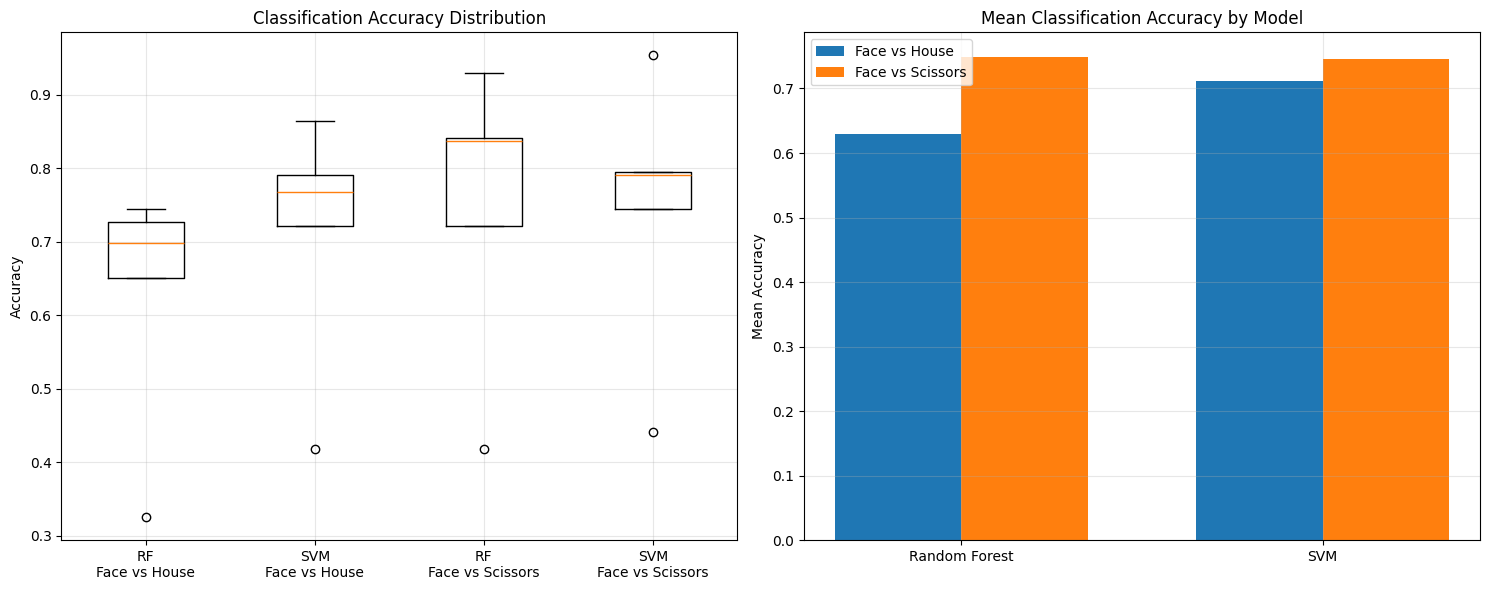

In [ ]:
vt_face_house = "vt_face_vs_house.csv"
vt_face_scissors = "vt_face_vs_scissors.csv"
run(vt_face_house, vt_face_scissors)

# Binary Classification of Inferior_frontal region (face vs house) and (face vs scissors)

=== VT Region Classification Analysis ===

Processing Inferior_frontal_face_vs_house.csv

Dataset Information:
Total samples: 216
face: 108 samples
house: 108 samples

Processing Inferior_frontal_face_vs_scissors.csv

Dataset Information:
Total samples: 216
face: 108 samples
scissors: 108 samples

Face vs House Split Information:
Training samples: 172 (86 class 0, 86 class 1)
Testing samples: 44 (22 class 0, 22 class 1)

Training RF for Face vs House...
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Test accuracy: 0.727
CV accuracy: 0.533 (+/- 0.132)

Training SVM for Face vs House...
Best parameters: {'C': 10, 'kernel': 'rbf'}
Test accuracy: 0.932
CV accuracy: 0.662 (+/- 0.229)

Face vs Scissors Split Information:
Training samples: 172 (86 class 0, 86 class 1)
Testing samples: 44 (22 class 0, 22 class 1)

Training RF for Face vs Scissors...
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Test accuracy: 0.864
CV accuracy:

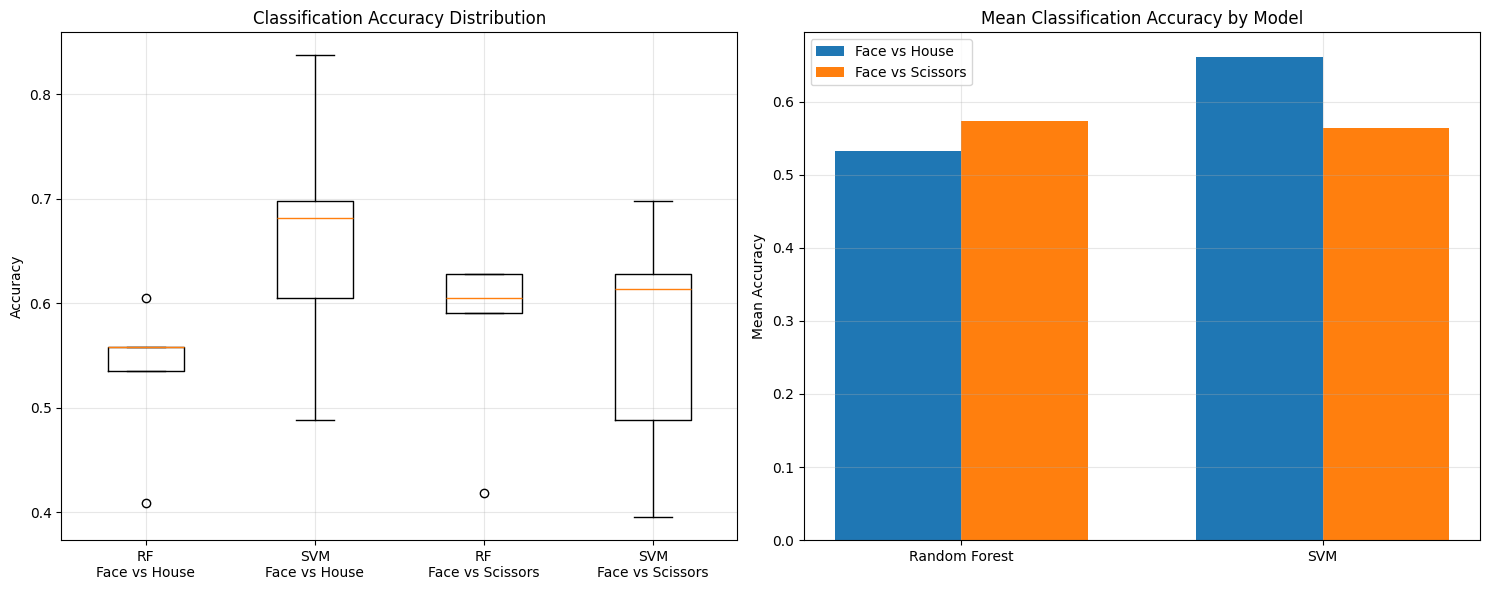

In [22]:
inferior_face_house = "Inferior_frontal_face_vs_house.csv"
inferior_face_scissors = "Inferior_frontal_face_vs_scissors.csv"
run(inferior_face_house, inferior_face_scissors)